In [1]:
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

import pandas as pd

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

In [2]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2022-01-26 18:02:20--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar.1’

postgresql-42.2.9.j 100%[===================>] 892.61K  4.47MB/s    in 0.2s    

2022-01-26 18:02:21 (4.47 MB/s) - ‘postgresql-42.2.9.jar.1’ saved [914037/914037]



In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("NewsPopularity").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://onlinenews-1.s3.us-west-1.amazonaws.com/OnlineNewsPopularity_clean.csv"
spark.sparkContext.addFile(url)
news_df = spark.read.csv(SparkFiles.get("OnlineNewsPopularity_clean.csv"), sep=",", header=True, inferSchema=True)

In [5]:
news_df.show()

+--------------------+---------+--------------+----------------+---------------+----------------+------------------------+---------+--------------+--------+----------+--------------------+------------+-------------------------+-----------------------------+-------------------+----------------------+--------------------+---------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------------------------+-------------------------+--------------------------+-----------------+------------------+--------------------+-------------------+-----------------+-------------------+-----------------+----------+-----------+-----------+-----------+-----------+-----------+-------------------+-------------------------+--------------------------+--------------------------+-------------------+-------------------+---------------------+----------------------+----------------------+---------------------+----------------------+---------------------

In [6]:
# Initial imports.
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [7]:
# Add shares per day column to make all articles the same 
online_news_df = news_df.withColumn("shares_per_day", news_df["shares"]/news_df["timedelta"])
online_news_df.show()

+--------------------+---------+--------------+----------------+---------------+----------------+------------------------+---------+--------------+--------+----------+--------------------+------------+-------------------------+-----------------------------+-------------------+----------------------+--------------------+---------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------------------------+-------------------------+--------------------------+-----------------+------------------+--------------------+-------------------+-----------------+-------------------+-----------------+----------+-----------+-----------+-----------+-----------+-----------+-------------------+-------------------------+--------------------------+--------------------------+-------------------+-------------------+---------------------+----------------------+----------------------+---------------------+----------------------+---------------------

In [8]:
# Drop URL, do not need 
new_online_news_df = online_news_df.drop("url")
new_online_news_df.show()


+---------+--------------+----------------+---------------+----------------+------------------------+---------+--------------+--------+----------+--------------------+------------+-------------------------+-----------------------------+-------------------+----------------------+--------------------+---------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------------------------+-------------------------+--------------------------+-----------------+------------------+--------------------+-------------------+-----------------+-------------------+-----------------+----------+-----------+-----------+-----------+-----------+-----------+-------------------+-------------------------+--------------------------+--------------------------+-------------------+-------------------+---------------------+----------------------+----------------------+---------------------+----------------------+----------------------+------------------+

In [9]:
# Convert to Pandas dataframe
pandas_df = new_online_news_df.toPandas()

In [10]:
# See the shares per day stats so we can decide what counts as 'popular'
pandas_df['shares_per_day'].describe()

count    39644.000000
mean        20.416778
std         92.109551
min          0.002532
25%          2.610952
50%          5.613140
75%         14.093960
max       5265.789474
Name: shares_per_day, dtype: float64

In [11]:
# From above, 14 is the 3rd Quartile 
pandas_df["is_popular"] = pandas_df['shares_per_day']>=14

In [12]:
pandas_df.drop(labels=['timedelta',  'shares' ,'shares_per_day'
       ], axis = 1, inplace=True)

In [13]:
# Define the features set.
X = pandas_df.copy()
X = X.drop("is_popular", axis=1)
X.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,12,219,0.663594,1.0,0.815385,4,2,1,0,4.680365,5,0,1,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1,0,0,0,0,0,0,0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500
1,9,255,0.604743,1.0,0.791946,3,1,1,0,4.913725,4,0,0,1,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,0,0,0,0,0,0,0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000
2,9,211,0.575130,1.0,0.663866,3,1,1,0,4.393365,6,0,0,1,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1,0,0,0,0,0,0,0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000
3,9,531,0.503788,1.0,0.665635,9,0,1,0,4.404896,7,0,1,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,0,0,0,0,0,0,0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000
4,13,1072,0.415646,1.0,0.540890,19,19,20,0,4.682836,7,0,0,0,0,1,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1,0,0,0,0,0,0,0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364


In [14]:
# Define the target set.
y = pandas_df["is_popular"]
y[:5]

0    False
1    False
2    False
3    False
4    False
Name: is_popular, dtype: bool

In [15]:
# Splitting into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [16]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [17]:
# Create a random forest regressor.
rf_model = RandomForestClassifier() 

In [18]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

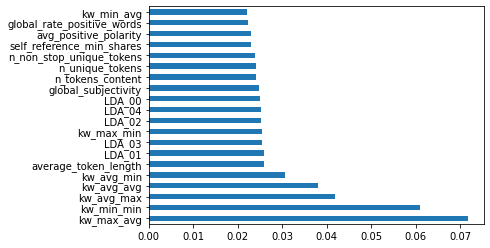

In [19]:
pd.Series(rf_model.feature_importances_, index = X.columns).nlargest(20).plot(kind = 'barh')

In [20]:
# Making predictions using the testing data.
predictions = rf_model.predict(X_test_scaled)

In [21]:
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_
importances

array([0.01756403, 0.02417972, 0.0241094 , 0.0006453 , 0.02384517,
       0.01990193, 0.01236652, 0.01866047, 0.00898896, 0.02592156,
       0.00950126, 0.00140827, 0.00326649, 0.00206121, 0.00153207,
       0.00244791, 0.00216594, 0.06090379, 0.02549399, 0.03073309,
       0.01749915, 0.01917393, 0.04188133, 0.02210388, 0.07172474,
       0.03815137, 0.02299967, 0.01991116, 0.02142847, 0.00297149,
       0.00285073, 0.00283125, 0.00286019, 0.0027482 , 0.00207785,
       0.00197056, 0.00308753, 0.02496928, 0.02590909, 0.02526282,
       0.02550315, 0.02524334, 0.02481955, 0.02113358, 0.02230939,
       0.02035816, 0.01750007, 0.01749224, 0.02298831, 0.01026644,
       0.00985653, 0.02163819, 0.01263288, 0.01218275, 0.01225854,
       0.01410375, 0.01049803, 0.01110537])

In [22]:
# We can sort the features by their importance.
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.07172474479593983, 'kw_max_avg'),
 (0.060903786527546695, 'kw_min_min'),
 (0.04188132548284786, 'kw_avg_max'),
 (0.03815136982208989, 'kw_avg_avg'),
 (0.030733089381651865, 'kw_avg_min'),
 (0.025921560176652897, 'average_token_length'),
 (0.025909090756888627, 'LDA_01'),
 (0.0255031455542958, 'LDA_03'),
 (0.025493985057543078, 'kw_max_min'),
 (0.025262821711287194, 'LDA_02'),
 (0.02524334182543856, 'LDA_04'),
 (0.024969279155935317, 'LDA_00'),
 (0.02481955113662031, 'global_subjectivity'),
 (0.024179722799627452, 'n_tokens_content'),
 (0.02410940145936366, 'n_unique_tokens'),
 (0.023845166237768767, 'n_non_stop_unique_tokens'),
 (0.02299966790572161, 'self_reference_min_shares'),
 (0.02298831005496917, 'avg_positive_polarity'),
 (0.022309390461933153, 'global_rate_positive_words'),
 (0.022103880145016474, 'kw_min_avg'),
 (0.02163818565642695, 'avg_negative_polarity'),
 (0.021428469033700045, 'self_reference_avg_sharess'),
 (0.02113357699938739, 'global_sentiment_polarity'),
 (0.020

In [23]:
# classification metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))

[[7106  307]
 [1777  721]]


In [24]:
print(classification_report(y_test,predictions))


              precision    recall  f1-score   support

       False       0.80      0.96      0.87      7413
        True       0.70      0.29      0.41      2498

    accuracy                           0.79      9911
   macro avg       0.75      0.62      0.64      9911
weighted avg       0.78      0.79      0.76      9911



In [25]:
print(accuracy_score(y_test, predictions))

0.7897285844011704
